In [3]:
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt

# 0. Data initialization

## 0.1 Source data

In [4]:
openmeteo = pd.read_pickle("Data/openmeteo.pickle")

pvgis = pd.read_pickle('Data/PVGIS.pickle')
pvgis = pvgis.xs('P', axis=1)
pvgis = pvgis["2016-05-01":"2020-12-31"]
pvgis = pvgis.tz_localize("UTC")



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38016 entries, 2016-05-01 00:00:00+00:00 to 2020-08-31 23:00:00+00:00
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   P                                 38016 non-null  float64
 1   temperature_2m                    38016 non-null  float32
 2   relative_humidity_2m              38016 non-null  float32
 3   pressure_msl                      38016 non-null  float32
 4   surface_pressure                  38016 non-null  float32
 5   cloud_cover                       38016 non-null  float32
 6   shortwave_radiation_instant       38016 non-null  float32
 7   diffuse_radiation_instant         38016 non-null  float32
 8   direct_normal_irradiance_instant  38016 non-null  float32
 9   wind_speed_10m                    38016 non-null  float32
 10  wind_direction_10m                38016 non-null  float32
 11  hour_sin            

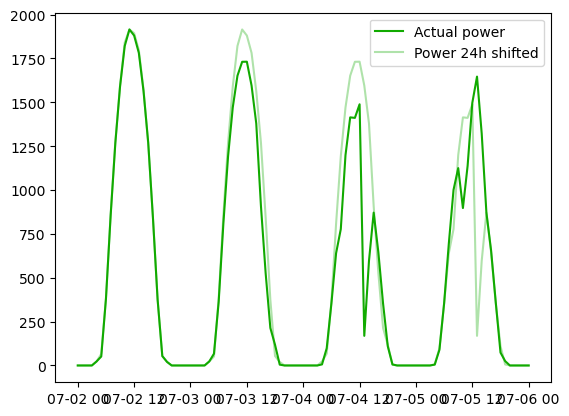

In [21]:
P = dataset['P']
P_24h= dataset["P_24h_shift"]
daterange = pd.date_range("2018-07-02", "2018-07-06", freq='h', tz="UTC")
plt.figure()
plt.plot(daterange, P[daterange],color="#11aa00", label="Actual power")
plt.plot(daterange, P_24h[daterange], color="#11aa0055", label="Power 24h shifted")
plt.legend()

## 0.2 Target data

In [16]:
installation_id = "3437BD60"
prodNL = pd.read_parquet('Data/production.parquet', engine='pyarrow')
metadata = pd.read_csv("Data/installations Netherlands.csv", sep=';')
metadata = metadata.set_index('id')
metadata_id = metadata.loc[installation_id]
tilt = metadata_id["Tilt"]
peakPower = metadata_id["Watt Peak"]
azimuth = metadata_id["Orientation"]
latitude = metadata_id["Latitude"]
longitude = metadata_id["Longitude"]
power = prodNL.loc[installation_id]
power = target_renamer(power, 'watt')
power.tail()

,watt
timestamp,
2021-08-09 19:30:00,0.0
2021-08-09 19:45:00,0.0
2021-08-09 20:00:00,0.0
2021-08-09 20:15:00,0.0
2021-08-09 20:30:00,0.0


# 1. Historic weather 

c:\Users\Robbe\PycharmProjects\SolNet 2\tensors\Tensorisation.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_tensor = torch.tensor(self.data[feature]).type(torch.float32)
c:\Users\Robbe\PycharmProjects\SolNet 2\tensors\Tensorisation.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_tensor = torch.tensor(self.data[feature]).type(torch.float32)


Shape of data:  torch.Size([1266, 24, 15]) torch.Size([317, 24, 15]) torch.Size([1266, 24, 1]) torch.Size([317, 24, 1])
LSTM(
  (lstm): LSTM(15, 100, num_layers=4, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=100, out_features=24, bias=True)
)
Step 0: Average train loss: 0.0407 | Average test loss: 0.0292
Step 5: Average train loss: 0.0144 | Average test loss: 0.0125
Step 10: Average train loss: 0.0091 | Average test loss: 0.0068
Step 15: Average train loss: 0.0069 | Average test loss: 0.0072
Step 20: Average train loss: 0.0047 | Average test loss: 0.0042
Step 25: Average train loss: 0.0051 | Average test loss: 0.0049
Step 30: Average train loss: 0.0040 | Average test loss: 0.0042
Step 35: Average train loss: 0.0035 | Average test loss: 0.0033
Step 40: Average train loss: 0.0043 | Average test loss: 0.0039
Step 45: Average train loss: 0.0034 | Average test loss: 0.0033
Step 50: Average train loss: 0.0031 | Average test loss: 0.0028
Step 55: Average train loss: 0.0026 |

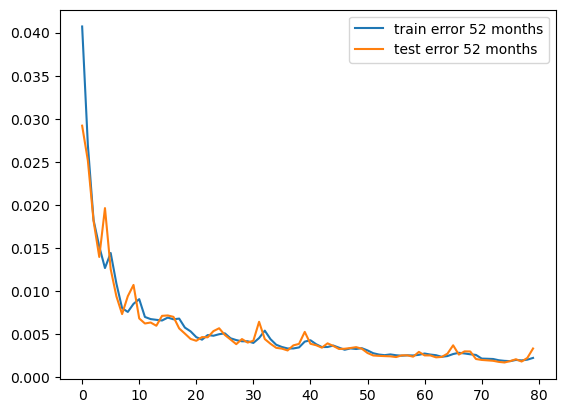

In [5]:
from main import source_trainer
from Data.Featurisation import Featurisation

data = pd.merge(pvgis, openmeteo, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')


source_dataset = data.data[0]
source_lstm, source_state, source_epoch = source_trainer(source_dataset, 24,24)